# Modelling tax defaults and fraud

This project tackles two problems common in corporate taxing using publicly available data on finnish companies. The first part of the modelling looks at predicting credit and tax repayment issues. The second, perhaps more interesting part aims to identify underreported taxable income, by predicting the distribution of future taxable income of a company based on ex-ante available data and identifying cases, where the reported taxable income is unlikely, given the predicted distribution of taxable income.

I use publically available taxation data, collected from Vero.fi, Finnish patent and registration office open data collected from http://avoindata.prh.fi/ and https://www.avoindata.fi/data/fi/dataset/prh-avoin-data and protest data, hand-collected from https://www.protestilista.com/. The protest list collects information on unpaid loans and tax liabilities. While the setting here is more of a credit default prediction, the largest submittor on the list is the Finnish tax authority.

The protest data is available from 2017, so I elect to train and validate the model on protests over one year from Novermber 2018 to November 2019. I assume that the tax return data is available at the start of November when it is publically released. I employ two classification models, a simple linear benchmark model . 

A "live" model with data up to November 2019 is available as a webapp at http://yritys-dash.herokuapp.com

The second, perhaps more interesting part of the project

In [6]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

## Data cleaning and feature engineering for 

In [30]:
#Import taxation and patent and registry office data
vero = pd.read_csv('verodata.csv', index_col=0)

# Form 
vero['Kunta'] = vero.Verotuskunta.str[:3].str.strip().fillna(vero.Verotuskunta).astype(int)
pienet = vero.Kunta.value_counts().index[vero.Kunta.value_counts() < 7446].values
vero.loc[vero.Kunta.isin(pienet),'Kunta'] = 0

vero.drop(['Verovelvollisen nimi', 'Verotuskunta'], 1, inplace=True)

#read in and dummy the public announcement types and aggregate to annual sums
records = pd.read_csv('records_processed.csv', index_col=0)
records = pd.get_dummies(records, columns=['typeOfRegistration'])
records.drop(['entryCodes', 'registrationDate'], 1, inplace=True)
records['Verovuosi'] = records.index.str[:4].astype(int)
records = records.groupby(['businessId', 'Verovuosi']).sum().reset_index()

#merge tax and records data
vero = pd.merge(vero, records, how='left', left_on=['Y-tunnus', 'Verovuosi'],
         right_on=['businessId', 'Verovuosi']).fillna(0).drop('businessId', 1)

vero['Muutokset'] = vero.iloc[:,8:-11].sum(1)
vero['Tyypit'] = vero.iloc[:,-12:-1].sum(1)
vero = vero.drop(vero.columns[7:87], 1)

C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
#read in firm-level data from patent office
prh = pd.read_csv('full_prh_data.csv', sep=';')
prh.business_line_code = prh.business_line_code.astype(str).str[:2].astype(int)

#construct firm age variable
prh['Age'] = (pd.to_datetime('2019-01-01') - \
              pd.to_datetime(prh.registration_date)).dt.days
prh = pd.get_dummies(prh, columns=['company_form'])

#construct values for general business area
prh.business_line_code.value_counts()
ls = [np.arange(1,3),
    np.arange(5,9),
    np.arange(10,33),
    [35],
    np.arange(36,39),
    np.arange(41,43),
    np.arange(45,47),
    np.arange(49,53),
    np.arange(55,56),
    np.arange(58,63),
    np.arange(64,66),
    [68],
    np.arange(69,75),
    np.arange(77,82),
    [84],
    [85],
    np.arange(86,88),
    np.arange(90,93),
    np.arange(94,96),
    np.arange(97,98),
    [99],
    [0]]
for i in range(len(ls)):
    prh['Toimiala{}'.format(i)] = prh.business_line_code.isin(ls[i]).astype(int)

prh = prh.drop(prh.columns[2:13], 1)
prh = prh.iloc[:,1:]
#re assemble dummies to categorical form
prh['Toimiala'] = prh.iloc[:,8:].idxmax(axis=1)
prh['Muoto'] = prh.iloc[:,2:8].idxmax(axis=1)
#drop all other columns
prh = prh.drop(prh.columns[2:-2], 1)

In [31]:
#merge with the tax data
vero = pd.merge(vero, prh, how='left', left_on=['Y-tunnus'],
         right_on=['business_id']).fillna(0).drop('business_id', 1)

In [40]:
#alter some data types
X = vero.set_index('Y-tunnus').reset_index()
X.columns = [col.replace('-', '') for col in X.columns]
X.Toimiala = X.Toimiala.astype(str)
X.Muoto = X.Muoto.astype(str)
#save the features to hdf and save a small sample hdf (for use in the web app)
X.to_hdf('predX.h5', key='X', complib='blosc', format='table', data_columns=['Ytunnus'])
X.iloc[:1,:].to_hdf('dumX.h5', key='X', complib='blosc', format='table', data_columns=['Ytunnus'])

In [129]:
X = pd.read_hdf('predX.h5', key='X')
X = pd.get_dummies(X, columns=['Muoto','Toimiala'], prefix=[None, None])
X.drop(['0'], 1, inplace=True)

In [130]:
#Run iterative multiplication and divisions to generate more potentially useful features for the dataset
features = X.columns[1:10]
for col in features:
    for col2 in features:
        X[col+'*'+col2] = (X[col2] * X[col])
for col in features:
    for col2 in features:
        X[col+'/'+col2] = (X[col2] / X[col])
        
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [131]:
#We are predicting results from 11/2018 to 11/2019, using tax data from 2017 onwards.
X = X[X.Verovuosi<2018]
#Aggregate to firm-level
X = X.groupby('Ytunnus').agg(['mean', 'last'])
X.columns = [' '.join(col) for col in X.columns]

In [184]:
#Finally read in the protest data
protests = pd.read_csv('protestit2.csv', index_col=0).set_index('0')
protests = protests.dropna()
protests['3'] = pd.to_datetime(protests['3'])
protests['2'] = protests['2'].str.replace('€','').astype(int)
protests.drop('1', 1, inplace=True)
protests.columns = ['Amount', 'date']
X_tr_protests = protests[(protests['date'] >= '2017-11-01')&\
        (protests['date'] < '2018-11-01')]
X_pr_protests = protests[(protests['date'] >= '2018-11-01')&\
        (protests['date'] < '2019-11-01')]

X_tr_protests = X_tr_protests.groupby(level=0).agg([sum, len])
X_pr_protests = X_pr_protests.groupby(level=0).agg([sum, len])
X_tr_protests.columns = [' '.join(col) for col in X_tr_protests.columns]
X_pr_protests.columns = [' '.join(col) for col in X_pr_protests.columns]

X = X.join(X_tr_protests).fillna(0)
X_pr_protests.to_hdf('X_protests.h5', key='X', complib='blosc', format='table')

In [199]:
ind = protests[(protests['date'] >= '2018-11-01')&\
               (protests['date'] < '2019-11-01')].index
X = X[X['Verovuosi last'] == 2017]
y = (X.index.isin(ind)).astype(int)

In [187]:
x_vars = X.var()
x_vars = x_vars[x_vars.duplicated(keep=False)].sort_values()
for var in x_vars.unique():
    if X.loc[:,x_vars[x_vars == var].index].corr().iloc[0,1] != 1:
        print(x_vars[x_vars == var].index)
        print(var)
X.drop(x_vars[x_vars.duplicated(keep='last')].index, 1, inplace=True)
pd.DataFrame(X.columns).to_csv('cols.csv', index=False)

Index(['Verovuosi/Verovuosi mean', 'Verovuosi/Verovuosi last'], dtype='object')
0.0


## Predictive modelling

In [200]:
#generate train and test sets with stratified k-fold
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
kfold = StratifiedKFold()

#### Logistic regression with set of engineered features

In [300]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.25)
log_pipe = Pipeline([('sclr', StandardScaler()), 
                      ('clf', logreg)])
log_pipe.fit(X_train, y_train)
print('Acc on train data: ', log_pipe.score(X_train, y_train))
print('Acc on test data: ', log_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, log_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, log_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9699956040442793
Acc on test data:  0.9700275746313392
Training benchmark:  0.9697238540542701 
Test benchmark:  0.9697238540542701
Log loss on train:  0.10926530763472413
Log loss on test:  0.11285660582809416
Training benchmark:  0.13570077236738876 
Test benchmark:  0.1356869185081214


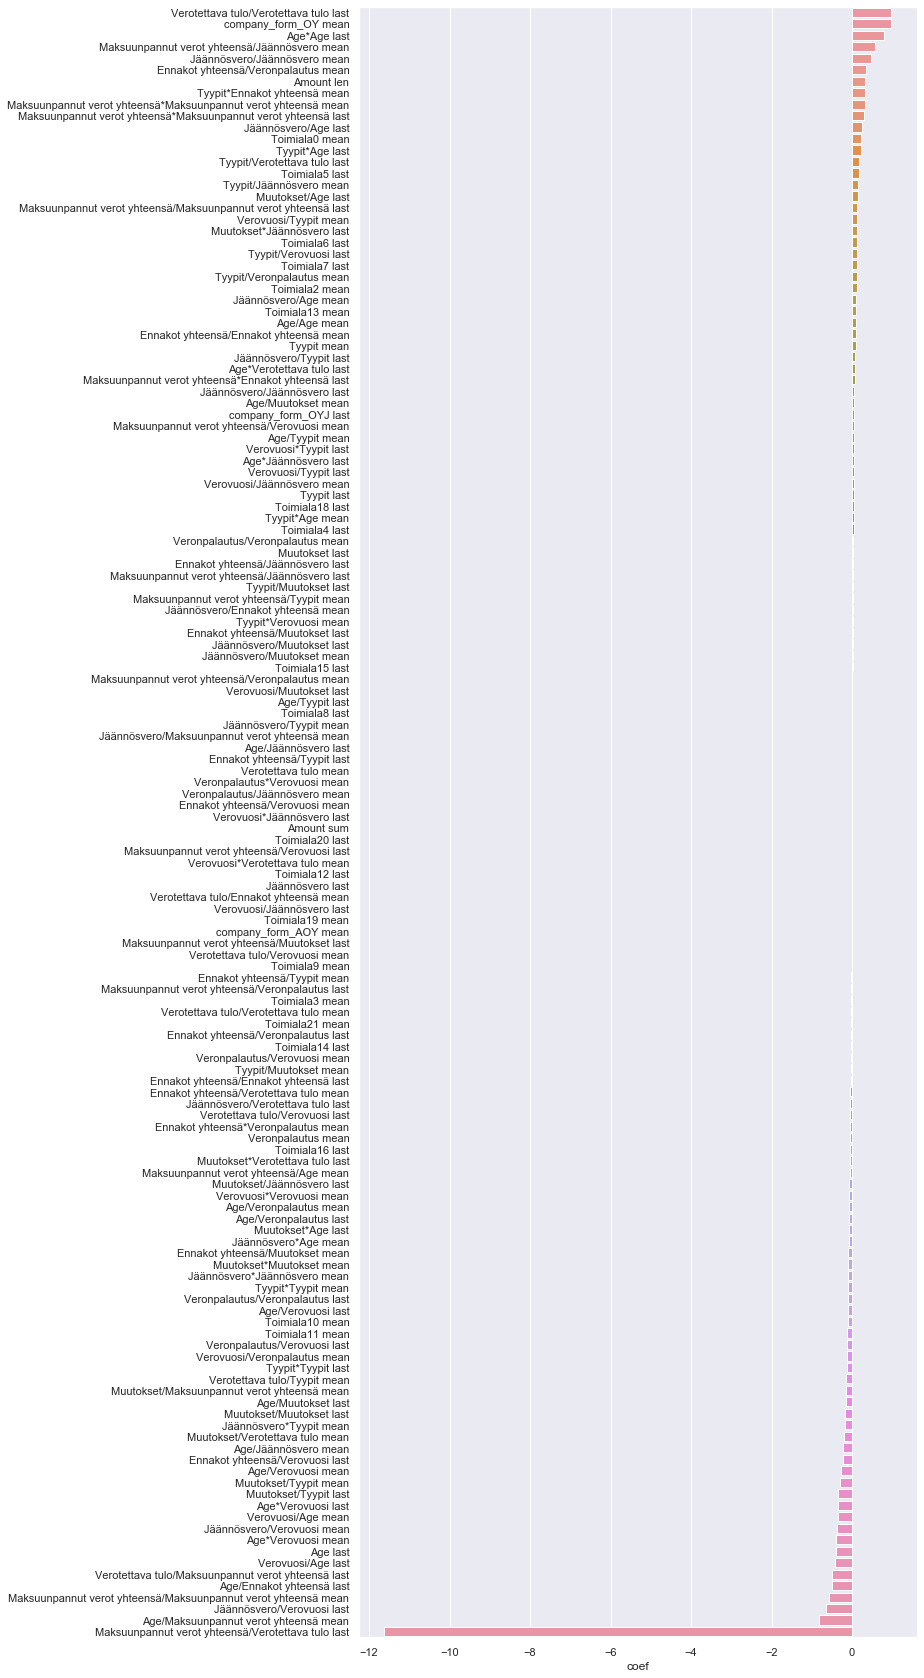

In [325]:
coef = log_pipe['clf'].coef_[0]
coef = pd.DataFrame(coef[coef != 0], index=X.columns[coef != 0], columns=['coef'])
coef = coef.sort_values('coef', ascending=False)
f, ax = plt.subplots(figsize=(10, 30))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef)

In [277]:
def plot_cols(col1, col2, ylim=None, xlim=None):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.regplot(x=col1, y=col2, data=X_test[y_test == 0],
                fit_reg=False, ax=ax, color='green')
    sns.regplot(x=col1, y=col2, data=X_test[y_test == 1],
                fit_reg=False, ax=ax, color='red')
    ax.legend(labels=['No protests', 'Protests'])
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    return None

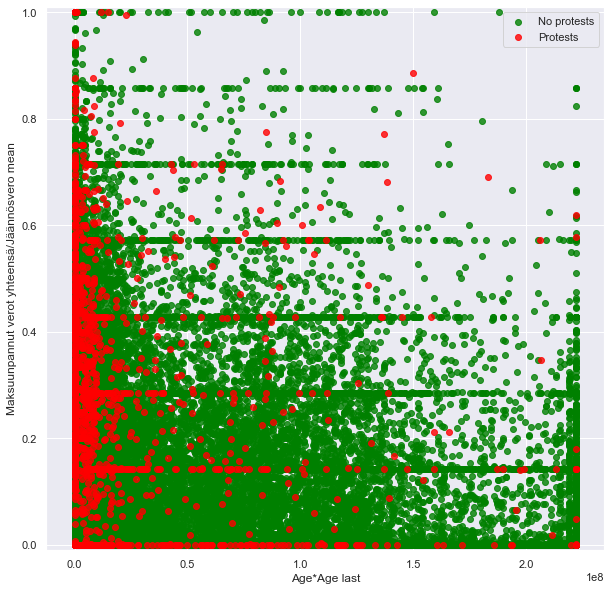

In [288]:
plot_cols('Age*Age last', 'Maksuunpannut verot yhteensä/Jäännösvero mean', ylim=(-0.01, 1.01))

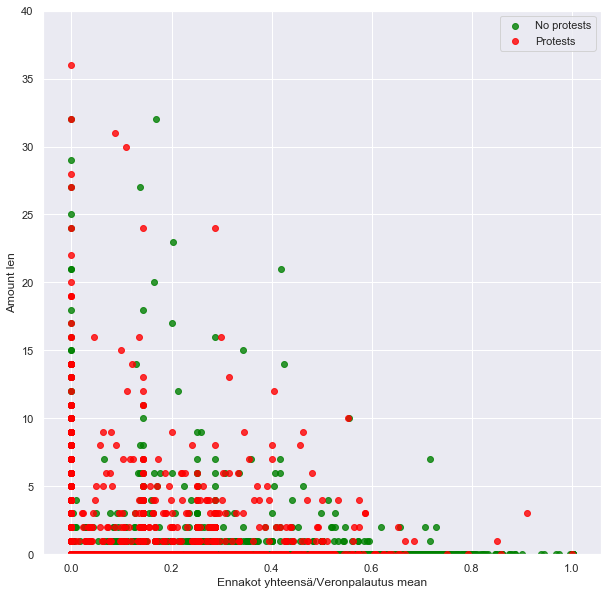

In [295]:
plot_cols('Ennakot yhteensä/Veronpalautus mean','Amount len', ylim=(-0.01,40))

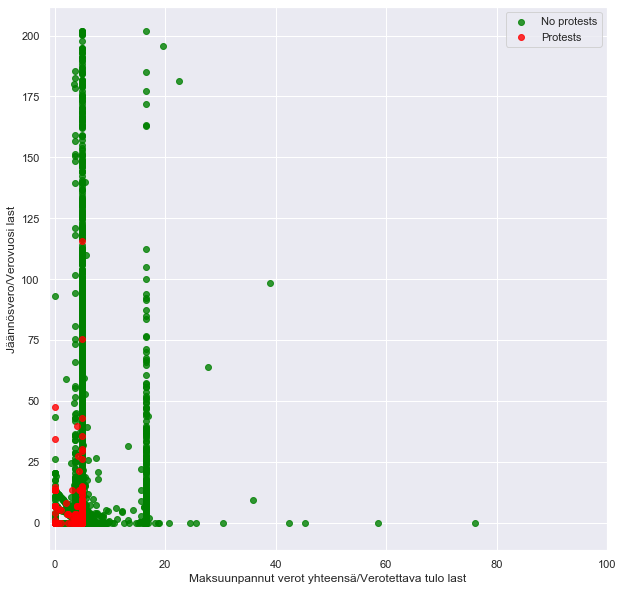

In [299]:
plot_cols('Maksuunpannut verot yhteensä/Verotettava tulo last',
          'Jäännösvero/Verovuosi last', xlim=(-1,100))

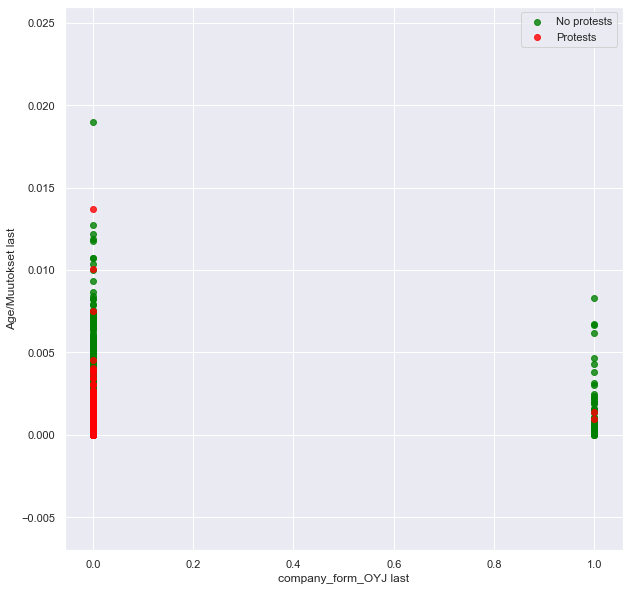

In [248]:
plot_cols('company_form_OYJ last','Age/Muutokset last')

In [258]:
params={
    'subsample': 0.9,
    'validation_fraction': 0.1, 
    'n_iter_no_change': 10,
    'learning_rate': 0.08,
    'n_estimators': 10000,
    'max_depth': 7,
    'min_samples_leaf': 20,
}
gbc = GradientBoostingClassifier(**params)
gb_pipe = Pipeline([('sclr', StandardScaler()), ('clf', gbc)])
gb_pipe.fit(X_train, y_train)
print('Acc on train data: ', gb_pipe.score(X_train, y_train))
print('Acc on test data: ', gb_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, gb_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, gb_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9757263317747672
Acc on test data:  0.9701354753626663
Training benchmark:  0.9697238540542701 
Test benchmark:  0.9697238540542701
Log loss on train:  0.08431454009571686
Log loss on test:  0.09483828999078664
Training benchmark:  0.13570077236738876 
Test benchmark:  0.1356869185081214


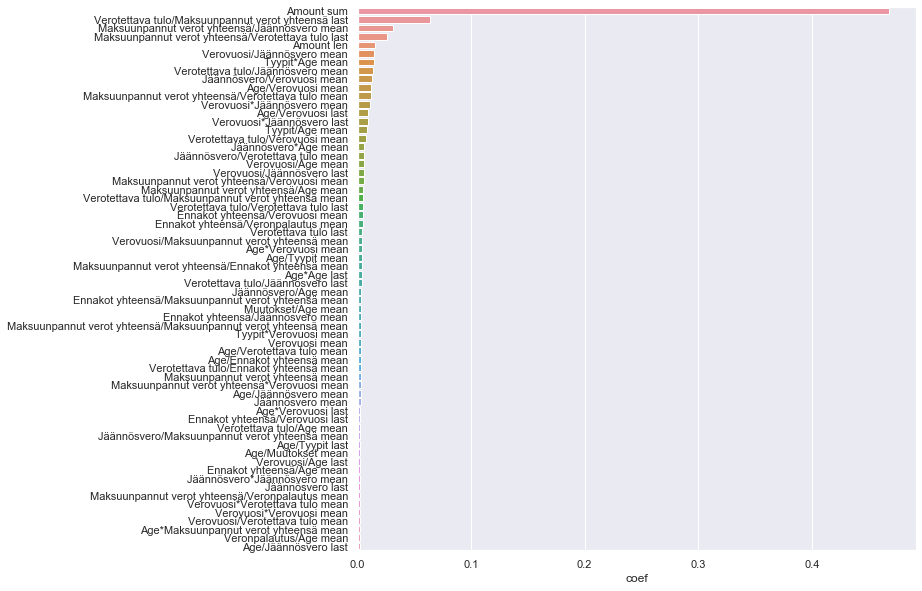

In [301]:
coef = gb_pipe['clf'].feature_importances_
coef = pd.DataFrame(coef[coef > 0.002], index=X.columns[coef > 0.002], columns=['coef'])
coef = coef.sort_values('coef', ascending=False)
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef)

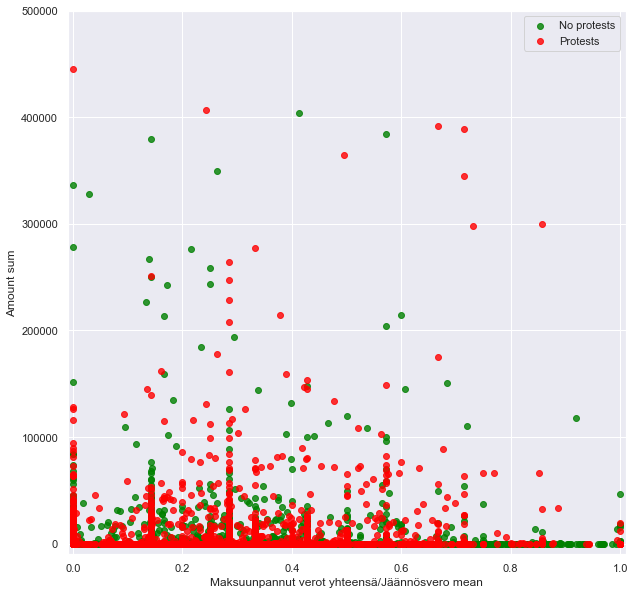

In [321]:
plot_cols('Maksuunpannut verot yhteensä/Jäännösvero mean', 'Amount sum',
          xlim=(-0.01, 1.01), ylim=(-10000, 500000))

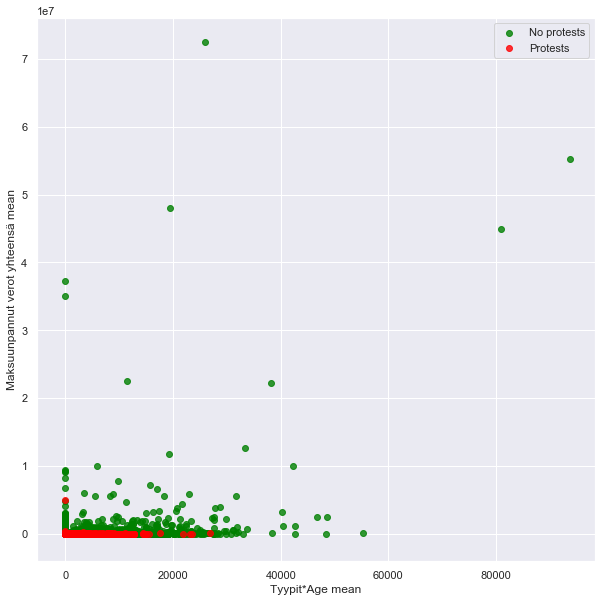

In [311]:
plot_cols('Tyypit*Age mean', 'Maksuunpannut verot yhteensä mean')

### Deep learning model

In [322]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [323]:
n_cols = X.shape[1]
input_shape = (n_cols,)

def create_model():
    # Specify the model
    model = Sequential()
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/2), input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/4), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
    return model

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nnc = KerasClassifier(build_fn=create_model, epochs=160, verbose=1)

In [324]:
nn_pipe = Pipeline([('sclr', MinMaxScaler()), ('clf', nnc)])
history = nn_pipe.fit(X_train, y_train, clf__validation_split=0.1,
                      clf__callbacks=[early_stopping_monitor])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 225207 samples, validate on 25023 samples
Epoch 1/160





225207/225207 [==============================] - 34s 149us/step - loss: 0.1201 - val_loss: 0.1074
Epoch 2/160
225207/225207 [==============================] - 35s 153us/step - loss: 0.1088 - val_loss: 0.1017
Epoch 3/160
225207/225207 [==============================] - 34s 152us/step - loss: 0.1041 - val_loss: 0.0990
Epoch 4/160
225207/225207 [==============================] - 35s 155us/step - loss: 0.1018 - val_loss: 0.0956
Epoch 5/160
225207/225207 [==============================] - 35s 157us/step - loss: 0.1002 - val_loss: 0.0955
Epoch 6/160
225207/225207 [==============================] - 35s 156us/step - loss: 0.0996 - val_loss: 0.0939
Epoch 7/160
225207/225207 [==============================] - 36s 160us/step - loss: 0.0989 - val_loss: 0.0931
Epoch 8/160
225207/225207 [==============================] - 35s 156us/s

In [53]:
print('Log loss on train: ', log_loss(y_train, nn_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, nn_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

250230/250230 [==============================] - 8s 33us/step
Log loss on train:  0.10599556824977337
83410/83410 [==============================] - 3s 32us/step
Log loss on test:  0.10692027131642057
Training benchmark:  0.13174406857663049 
Test benchmark:  0.13175807979994478


In [326]:
import pickle
pickle.dump(log_pipe, open('logit.pkl', 'wb'))
pickle.dump(gb_pipe, open('gb.pkl', 'wb'))
nn_pipe['clf'].model.save('nn.h5')

In [373]:
tr_preds = np.array([log_pipe.predict_proba(X_train)[:,1],
           nn_pipe.predict_proba(X_train)[:,1],
           gb_pipe.predict_proba(X_train)[:,1]])
ts_preds = np.array([log_pipe.predict_proba(X_test)[:,1],
           nn_pipe.predict_proba(X_test)[:,1],
           gb_pipe.predict_proba(X_test)[:,1]])
wt=[2,6,10]
print('Log loss on train: ', log_loss(y_train, np.average(tr_preds,0, weights=wt)))
print('Log loss on test: ', log_loss(y_test, np.average(ts_preds,0, weights=wt)))

83410/83410 [==============================] - 2s 24us/step
Log loss on train:  0.08744235710483073
Log loss on test:  0.09434415245149247


In [450]:
from scipy.stats import chi2
import keras.backend as K

bm_ll = -log_loss(y_test,np.repeat(y_train.mean(), len(y_test)), normalize=False)

df = X_test.shape[1]
ll = -log_loss(y_test, ts_preds[0,:], normalize=False)
G = 2 * (ll - bm_ll)
p_value = chi2.sf(G, df)
print('P-value for logistic model: ', p_value)


df = np.sum([K.count_params(w) for w in\
                          nn_pipe['clf'].model.trainable_weights])
ll = -log_loss(y_test, ts_preds[1,:], normalize=False)
G = 2 * (ll - bm_ll)
p_value = chi2.sf(G, df)
print('P-value for neural network: ', p_value)

df = 0
for est in gb_pipe['clf'].estimators_:
    df += est[0].get_depth()
ll = -log_loss(y_test, ts_preds[2,:], normalize=False)
G = 2 * (ll - bm_ll)
p_value = chi2.sf(G, df)
print('P-value for gradient boosting model: ', p_value)

P-value for logistic model:  0.0
P-value for neural network:  1.0
P-value for gradient boosting model:  0.0
